# Workshop

## Agenda 
- MNIST Dataset
- Dense Neural Network
- Training
- Visualization of results

## MNIST Dataset

The MNIST (Modified National Institute of Standards and Technology) dataset is a labeled collection containing images of handwritten numbers. 

![MNIST](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

The machine learning task is to classify the images, i.e. given 28 x 28 pixels of that input image, output the integer displayed on that image. This is a typical benchmark for image processing and machine learning.

We can download and prepare the dataset using torchvision. Here, we us a default splitting of the database in a training set containing 60000 samples and a test set containing 10000 samples. We will use the training set to optimize our machine learning model and then the different test set to evaluate the general performance of our model. 

In [2]:
from torchvision import datasets

train_data = datasets.MNIST(root="data", train=True, download=True)
test_data = datasets.MNIST(root="data", train=False)

Let's take a look at a sample of the dataset: 

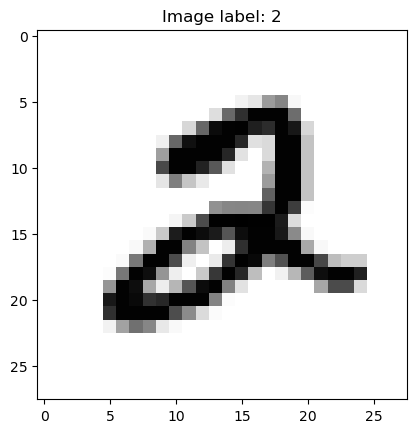

In [3]:
import matplotlib.pyplot as plt

sample = 5 # sample between 0 and 59999
plt.imshow(train_data.data[sample], cmap='gray_r')
plt.title(f"Image label: {train_data.targets[sample]}")
plt.show()

In [4]:
# Prepare training dataset
train_images = train_data.data.float() / 255.0
train_labels = train_data.targets

# Preprare test dataset
test_images = test_data.data.float() / 255.0
test_labels = test_data.targets

## Create a dense neural network

First, we try a dense neural network to solve the image classification task. For each artificial neuron in each layer, this NN does the following: 

Compute the weighted ($w_i$) sum of all inputs $x_i$ and a bias $b$
$$
\tilde{x} = \sum_i w_i x_i + b.
$$
Then apply an activation function to this intermediate result 
$$
x = f(\tilde{x}),
$$
which is a sigmoid function defined as 
$$
f(x) = \frac{1}{1+\exp^{-x}}
$$
in this case. The activation function allows us to model non-linear classification tasks. 

Our dense neural network consists of multiple such layers with 784 (28 x 28) at the first input layer, and 10 output neurons. Hence, we can pass an image of 784 pixels into the neural network and will get 10 outputs, each encoding the likelihood of a label. So, with a proper choice of weights and biases in the network, we expect it to produce a result like this, e.g. if we pass in an image showing a two:

|0|1|2|3|4|5|6|7|8|9|
|-|-|-|-|-|-|-|-|-|-|
|0.01|0.05|0.99|0.01|0.03|0.06|0.00|0.12|0.07|0.02|

In [5]:
import torch
import torch.nn as nn

class DenseNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.layer1 = nn.Linear(784, 100)
      self.layer2 = nn.Linear(100, 10)

    def forward(self, x):
      x = self.layer1(x)
      x = torch.sigmoid(x)
      x = self.layer2(x)
      x = torch.sigmoid(x)
      return x
    
dense_net = DenseNet()

## Training

Initially, the weights and biases are set to random values. Hence, it is pure luck, if the network would predict the correct result at this point. We can describe the quality of its prediction for example with the so-called cross-entropy loss
$$
 L(p, l) = -\sum_{c=0}^N l_c \log(p_c)
$$
for $N$ different classes with predictions $p_c$ and labels $l_c$. In our case, $N=10$. 

During training, we try to adjust the weights of a neural network to reduce the error. Therefore, we use a gradient decent algortihm (in this case Adam) to minimize the error. This is done by calling `loss.backward()`to compute the gradient of the loss function and then adjusting the weights a tiny bit (`lr`) against the direction of that gradient with `optimizer.step()`. This latest part is the real "magic" in training neural networks and requires an automatic differentiation engine, such as PyTorch, JAX or TensorFlow.

In [6]:
from torch import optim

optimizer = optim.Adam(dense_net.parameters(), lr = 0.01)   
loss_function = nn.CrossEntropyLoss()

train_accuracy = []
test_accuracy = []

for epoch in range(200):
    # Pass images through network and compute loss 
    # The flatten() command turns the 600000 x 28 x 28 to 60000 x 784
    train_prediction = dense_net(train_images.flatten(start_dim=1))
    test_prediction = dense_net(test_images.flatten(start_dim=1))

    # Compute loss on training set
    loss = loss_function(train_prediction, train_labels)
    
    # Evaluate accuracies (argmax extracts the index of the highest value in tensor)
    is_corrrect = torch.argmax(train_prediction, 1) == train_labels
    train_accuracy.append(is_corrrect.sum()/len(train_labels))
    is_corrrect = torch.argmax(test_prediction, 1) == test_labels
    test_accuracy.append(is_corrrect.sum()/len(test_labels))

    # Improve network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f"Final accuracy on test set is {test_accuracy[-1]:.3f}")


Final accuracy on test set is 0.948


## Visualization of results

During training we saved the accuracy on the training set and test set:

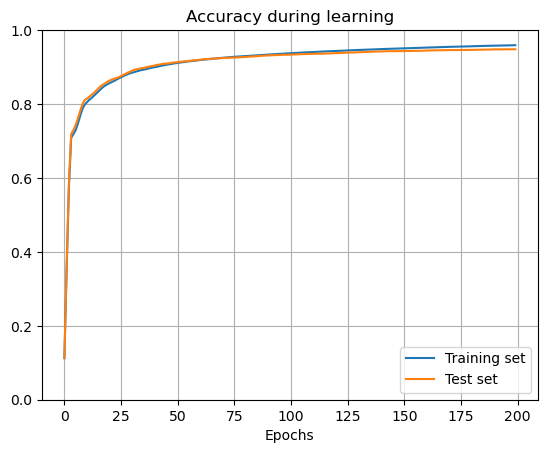

In [7]:
import matplotlib.pyplot as plt 

plt.plot(train_accuracy, label="Training set")
plt.plot(test_accuracy, label="Test set")
plt.title("Accuracy during learning")
plt.xlabel("Epochs")
plt.ylim([0,1])
plt.legend()
plt.grid()
plt.show()

Let's tak a look at a couple of classified samples

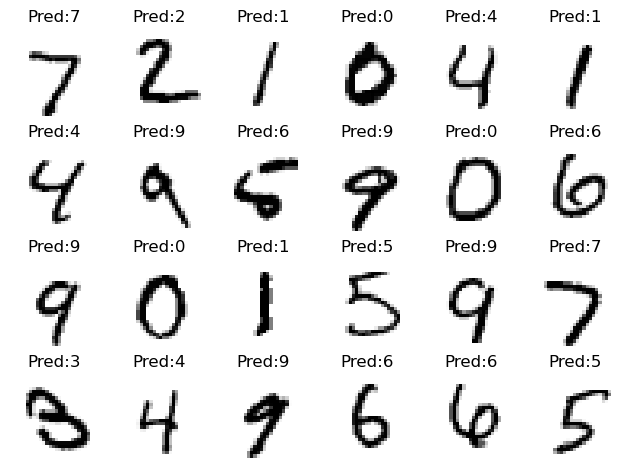

In [8]:
n_rows = 4 
n_cols = 6

fig, ax = plt.subplots(n_rows, n_cols)
n = 0
for i in range(n_rows):
    for j in range(n_cols):
        pred = torch.argmax(dense_net(test_images[n].flatten()))
        ax[i,j].imshow(test_data.data[n], cmap="gray_r")
        ax[i,j].set_axis_off()
        ax[i,j].set_title(f"Pred:{pred}")
        n += 1

plt.tight_layout()

## Create a convolutional neural network

The demonstrated example works nicely, however we need to train a lot of weights and the simple model won't be able to get towards superior accuracy. A better approach for image processing are convolutional neural networks. Here, we use a standard network architecture for the MNIST Dataset:

![Convolutional Neural Network](data/conv_net.png)


In [9]:
class ConvolutionalNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 32, 5)
      self.conv2 = nn.Conv2d(32, 64, 5)
      self.dropout1 = nn.Dropout(0.25)
      self.dropout2 = nn.Dropout(0.5)
      self.fc1 = nn.Linear(6400, 128)
      self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
      # Pass through first convolutional layer with a 5x5 kernel
      x = self.conv1(x)
      x = torch.relu(x)
      # Pass through second convolutional layer with a 5x5 kernel
      x = self.conv2(x)
      x = torch.relu(x)
      # For groups of 2x2 pixels pass only the maximum value
      x = torch.max_pool2d(x, 2)
      # Randomly zero some elements
      x = self.dropout1(x)
      # Flatten latest tensor to a vector
      x = torch.flatten(x, 1)
      # Pass through first fully connected layer
      x = self.fc1(x)
      x = torch.relu(x)
      # Randomly zero some elements
      x = self.dropout2(x)
      # Pass through second fully connected layer
      x = self.fc2(x)
      return torch.log_softmax(x, dim=1)
    
conv_net = ConvolutionalNet()

Here, we use data loaders to get batches of datasets and manipulate the items with ToTensor instead of the previous manual data prepartaion:

In [10]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(root="data", train=True, transform=ToTensor())
test_data = datasets.MNIST(root="data", train=False, transform=ToTensor())

training_loader = DataLoader(train_data, batch_size=100)
test_loader = DataLoader(test_data, batch_size=10000)

In [11]:
optimizer = optim.Adam(conv_net.parameters(), lr = 0.01)   
loss_function = nn.CrossEntropyLoss()

conv_net.train()

for epoch in range(10):
    for images, labels in training_loader:
        # Pass images through network and compute loss 
        train_prediction = conv_net(images)
        # Compute loss on training set
        loss = loss_function(train_prediction, labels)
        # Improve network weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Loss after epoch {epoch}: {loss.item()}")



Loss after epoch 0: 0.19228389859199524
Loss after epoch 1: 0.3954322040081024
Loss after epoch 2: 0.5075643062591553
Loss after epoch 3: 0.2637990713119507
Loss after epoch 4: 0.15629181265830994
Loss after epoch 5: 0.3189929127693176
Loss after epoch 6: 0.4367193877696991
Loss after epoch 7: 0.47561946511268616
Loss after epoch 8: 0.20837782323360443
Loss after epoch 9: 0.5018986463546753


In [12]:
conv_net.eval()

for images, labels in test_loader:
    test_prediction = conv_net(images)
    is_corrrect = torch.argmax(test_prediction, 1) == labels
    accuracy = is_corrrect.sum() / len(labels) * 100.0
    print(f"Test batch accuracy with {len(labels)} samples is {accuracy:.2f}%.")

Test batch accuracy with 10000 samples is 98.57%.


Currently, the best results on the MNIST dataset achieve 99.82%. It is unlikely to get to 100% accuracy, as some digits are very ambiguous...